# Prédiction du temps de livraison


## 1. Import des bibliothèques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

## 2. Chargement et exploration des données

In [2]:
# Charger le dataset
df = pd.read_csv('/content/deliverytime.csv')

# Aperçu
df.head(), df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24378 entries, 0 to 24377
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           24378 non-null  object 
 1   Delivery_person_ID           24378 non-null  object 
 2   Delivery_person_Age          24377 non-null  float64
 3   Delivery_person_Ratings      24377 non-null  float64
 4   Restaurant_latitude          24377 non-null  float64
 5   Restaurant_longitude         24377 non-null  float64
 6   Delivery_location_latitude   24377 non-null  float64
 7   Delivery_location_longitude  24377 non-null  float64
 8   Type_of_order                24377 non-null  object 
 9   Type_of_vehicle              24377 non-null  object 
 10  Time_taken(min)              24377 non-null  float64
dtypes: float64(7), object(4)
memory usage: 2.0+ MB


(     ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
 0  4607     INDORES13DEL02                 37.0                      4.9   
 1  B379     BANGRES18DEL02                 34.0                      4.5   
 2  5D6D     BANGRES19DEL01                 23.0                      4.4   
 3  7A6A    COIMBRES13DEL02                 38.0                      4.7   
 4  70A2     CHENRES12DEL01                 32.0                      4.6   
 
    Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
 0            22.745049             75.892471                   22.765049   
 1            12.913041             77.683237                   13.043041   
 2            12.914264             77.678400                   12.924264   
 3            11.003669             76.976494                   11.053669   
 4            12.972793             80.249982                   13.012793   
 
    Delivery_location_longitude Type_of_order Type_of_vehicle  Time_take

In [33]:
df.head()

,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min),distance_km
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24.0,3.025149
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33.0,20.183530
2,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26.0,1.552758
3,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21.0,7.790401
4,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30.0,6.210138


## 3. Nettoyage et prétraitement

In [3]:
# Suppression de colonnes inutiles
df = df.drop(columns=['ID'])

# Correction des notes supérieures à 5
df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].clip(upper=5)

# Fonction Haversine pour la distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

df['distance_km'] = haversine(
    df['Restaurant_latitude'], df['Restaurant_longitude'],
    df['Delivery_location_latitude'], df['Delivery_location_longitude']
)
df['distance_km'].describe()

,distance_km
count,24377.000000
mean,95.463213
std,1071.202501
min,1.465067
25%,4.663432
50%,9.264649
75%,13.765757
max,19688.001288


## 4. Ingénierie des caractéristiques

In [4]:
numeric_features = ['Delivery_person_Age', 'Delivery_person_Ratings', 'distance_km']
categorical_features = ['Type_of_order', 'Type_of_vehicle']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

## 5. Analyse exploratoire des données

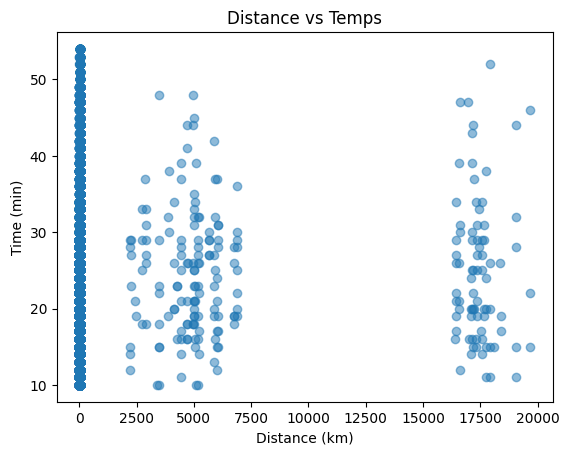

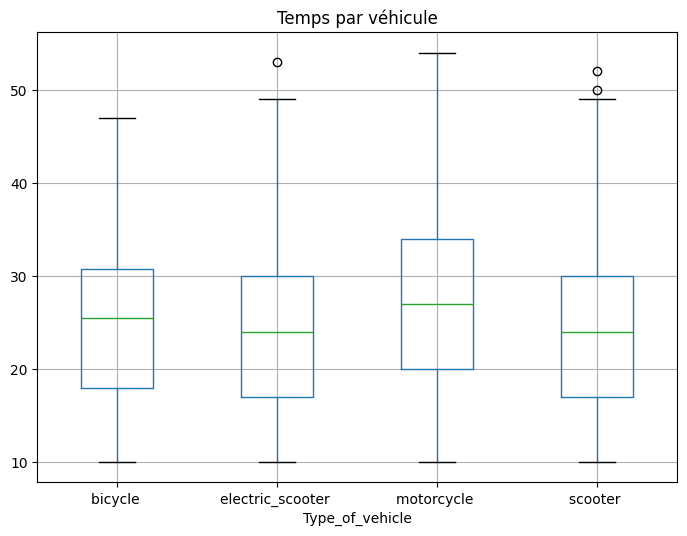

In [5]:
plt.scatter(df['distance_km'], df['Time_taken(min)'], alpha=0.5)
plt.xlabel('Distance (km)')
plt.ylabel('Time (min)')
plt.title('Distance vs Temps')
plt.show()

df.boxplot(column='Time_taken(min)', by='Type_of_vehicle', figsize=(8,6))
plt.title('Temps par véhicule')
plt.suptitle('')
plt.show()

## 6. Modélisation et évaluation initiale

In [7]:
# Combien de NaN par colonne ?
print(df[numeric_features + categorical_features].isnull().sum())


Delivery_person_Age        1
Delivery_person_Ratings    1
distance_km                1
Type_of_order              1
Type_of_vehicle            1
dtype: int64


In [9]:
# Suppression de la ligne où il manque au moins une valeur
df = df.dropna(subset=numeric_features + categorical_features + ['Time_taken(min)'])

# Puis recréer X, y, et refaire train_test_split…


In [10]:
X = df[numeric_features + categorical_features]
y = df['Time_taken(min)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

baseline = Pipeline([('preprocessor', preprocessor), ('regressor', LinearRegression())])
baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)

print('MAE:', mean_absolute_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))

MAE: 6.691488668658917
RMSE: 8.431811153334149
R2: 0.21452344592929007


In [12]:
from sklearn.ensemble import RandomForestRegressor

# Pipeline RF sans tuning
rf_baseline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

rf_baseline.fit(X_train, y_train)
y_rf = rf_baseline.predict(X_test)

print("RandomForest (défaut) • MAE: ", mean_absolute_error(y_test, y_rf))
print("RandomForest (défaut) • RMSE:", np.sqrt(mean_squared_error(y_test, y_rf)))
print("RandomForest (défaut) • R2:  ", r2_score(y_test, y_rf))


RandomForest (défaut) • MAE:  6.076940588499551
RandomForest (défaut) • RMSE: 7.780080395692103
RandomForest (défaut) • R2:   0.33125637721724455


In [13]:
from sklearn.model_selection import GridSearchCV

# Grille à explorer
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth':    [None, 10, 20],
    'regressor__min_samples_split': [2, 5],
}

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

grid_rf = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
y_best_rf = best_rf.predict(X_test)

print("Meilleurs params RF :", grid_rf.best_params_)
print("RF optimisé • MAE: ", mean_absolute_error(y_test, y_best_rf))
print("RF optimisé • RMSE:", np.sqrt(mean_squared_error(y_test, y_best_rf)))
print("RF optimisé • R2:  ", r2_score(y_test, y_best_rf))


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Meilleurs params RF : {'regressor__max_depth': 10, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
RF optimisé • MAE:  5.753671717140165
RF optimisé • RMSE: 7.326058689540617
RF optimisé • R2:   0.40703061550075215


In [14]:
from xgboost import XGBRegressor

# Pipeline XGBoost par défaut
xgb_baseline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, eval_metric='mae'))
])

xgb_baseline.fit(X_train, y_train)
y_xgb = xgb_baseline.predict(X_test)

print("XGBoost (défaut) • MAE: ", mean_absolute_error(y_test, y_xgb))
print("XGBoost (défaut) • RMSE:", np.sqrt(mean_squared_error(y_test, y_xgb)))
print("XGBoost (défaut) • R2:  ", r2_score(y_test, y_xgb))


XGBoost (défaut) • MAE:  5.860686442419777
XGBoost (défaut) • RMSE: 7.47211801352253
XGBoost (défaut) • R2:   0.3831509093101093


In [15]:
param_grid_xgb = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth':    [3, 6, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
}

grid_xgb = GridSearchCV(
    xgb_baseline,
    param_grid_xgb,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
grid_xgb.fit(X_train, y_train)

best_xgb = grid_xgb.best_estimator_
y_best_xgb = best_xgb.predict(X_test)

print("Meilleurs params XGB :", grid_xgb.best_params_)
print("XGB optimisé • MAE: ", mean_absolute_error(y_test, y_best_xgb))
print("XGB optimisé • RMSE:", np.sqrt(mean_squared_error(y_test, y_best_xgb)))
print("XGB optimisé • R2:  ", r2_score(y_test, y_best_xgb))


Meilleurs params XGB : {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 200}
XGB optimisé • MAE:  5.739276069612949
XGB optimisé • RMSE: 7.292596826271325
XGB optimisé • R2:   0.41243503480311383


In [18]:
from sklearn.ensemble import StackingRegressor

stack = StackingRegressor(
    estimators=[
        ('rf',  grid_rf.best_estimator_),
        ('xgb', grid_xgb.best_estimator_)
    ],
    final_estimator=LinearRegression(),
    n_jobs=-1
)

# Entraînement directement sur DataFrame + Series
stack.fit(X_train, y_train)
y_stack = stack.predict(X_test)

print("Stacking • MAE: ", mean_absolute_error(y_test, y_stack))
print("Stacking • RMSE:", np.sqrt(mean_squared_error(y_test, y_stack)))
print("Stacking • R2:  ", r2_score(y_test, y_stack))


Stacking • MAE:  5.729201811906688
Stacking • RMSE: 7.2842491976605555
Stacking • R2:   0.41377940281167913


## 7. Interprétation

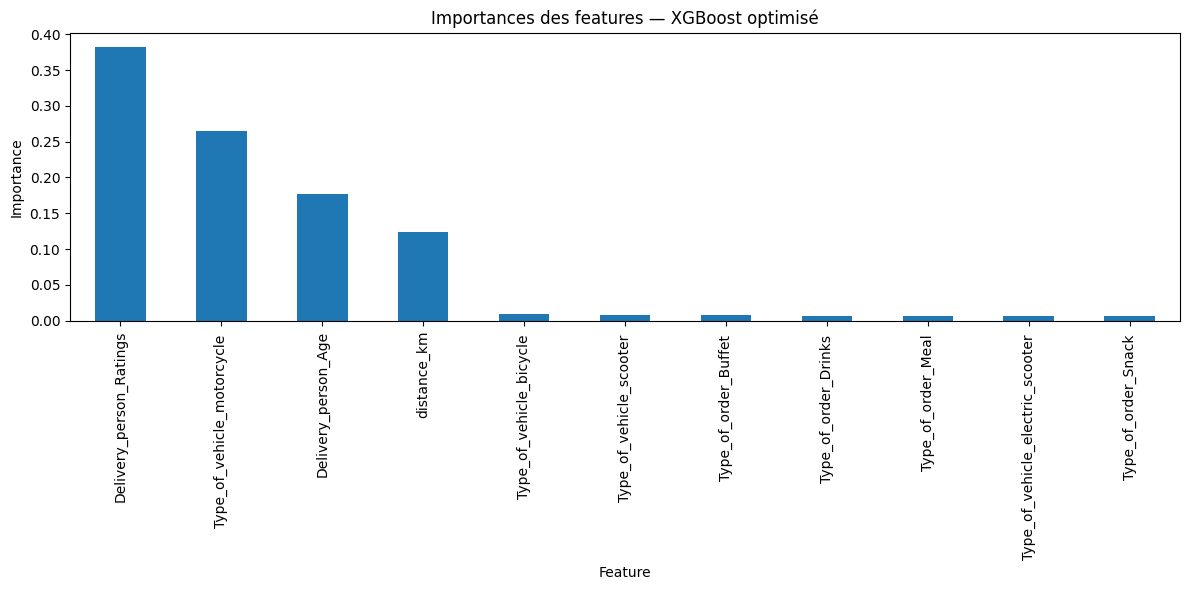

In [21]:
# Interprétation : importances des features — XGBoost optimisé
import pandas as pd
import matplotlib.pyplot as plt

# 1) Récupérer le modèle pur
xgb_model = grid_xgb.best_estimator_.named_steps['regressor']

# 2) Extraire importances et noms de features
importances = xgb_model.feature_importances_
feature_names = (
    numeric_features
    + list(
        grid_xgb.best_estimator_
        .named_steps['preprocessor']
        .named_transformers_['cat']
        .named_steps['onehot']
        .get_feature_names_out(categorical_features)
    )
)

# 3) Construire la série et tracer
feat_imp = pd.Series(importances, index=feature_names) \
             .sort_values(ascending=False)

plt.figure(figsize=(12, 6))
feat_imp.plot(kind='bar')
plt.title("Importances des features — XGBoost optimisé")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()


## 8. Sauvegarde du modèle

In [30]:
# Votre pipeline complet XGB
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(**grid_xgb.best_params_, random_state=42, eval_metric='mae'))
])
xgb_pipeline.fit(X_train, y_train)

# Sauvegarde du pipeline entier
import joblib
joblib.dump(xgb_pipeline, '/content/delivery_xgb_pipeline.joblib')


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:41:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "regressor__learning_rate", "regressor__max_depth", "regressor__n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


['/content/delivery_xgb_pipeline.joblib']

## 9.Exemple de prédiction

In [34]:
import joblib, pandas as pd

# 1) Charger le pipeline complet
pipeline = joblib.load('/content/delivery_xgb_pipeline.joblib')

# 2) Construire un nouveau sample (avec **exactement** vos colonnes d’entrée)
new_sample = pd.DataFrame([{
    'Delivery_person_Age':      37.0   ,
    'Delivery_person_Ratings':  4.9,
    'distance_km':              3.025149,
    'Type_of_order':           'Snack	',
    'Type_of_vehicle':         'motorcycle',
    # … les autres features si vous en avez ajouté
}])

# 3) Prédiction (le pipeline s’occupe de tout transformer)
pred = pipeline.predict(new_sample)[0]
print(f"Temps estimé : {pred:.2f} minutes")


Temps estimé : 19.01 minutes
